In [1]:
# Step 1: Install & Import Libraries
!pip install -q seaborn plotly

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest

# Load data
df = pd.read_csv('/content/smart_logistics_dataset.csv')
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.sort_values(by='Timestamp', inplace=True)
df.reset_index(drop=True, inplace=True)


**EDA**

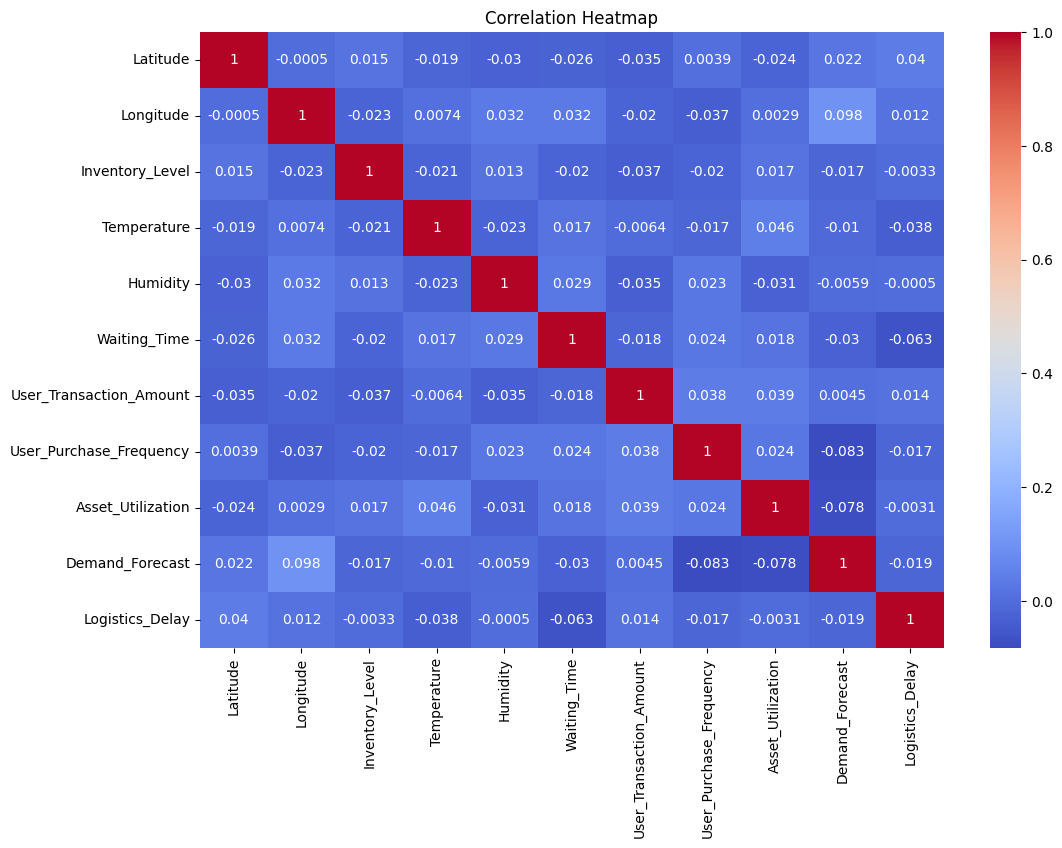

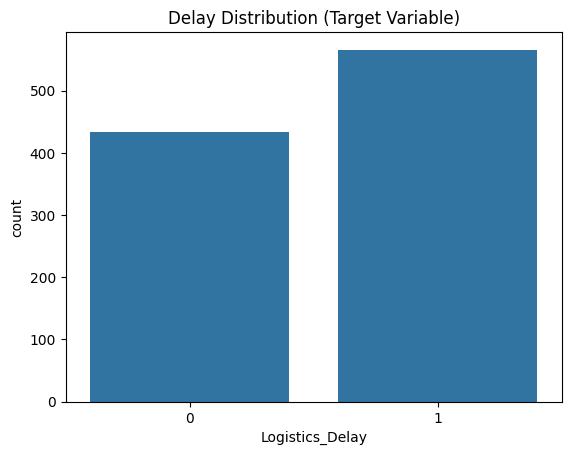

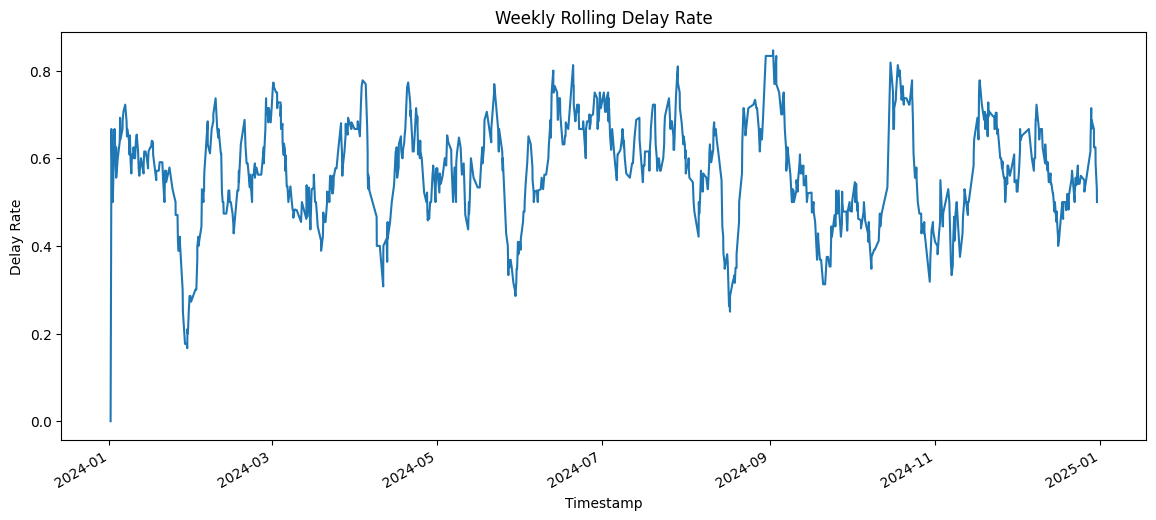

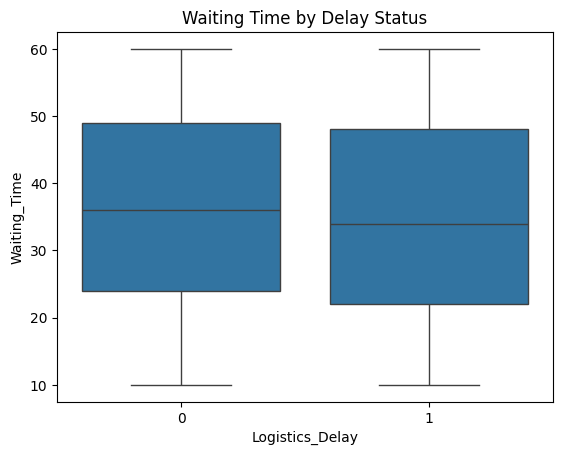

In [2]:
# EDA 1: Correlation heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(df.select_dtypes(include=np.number).corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()

# EDA 2: Delay distribution
sns.countplot(data=df, x='Logistics_Delay')
plt.title("Delay Distribution (Target Variable)")
plt.show()

# EDA 3: Time-series of delays
plt.figure(figsize=(14, 6))
df['Delay_Flag'] = df['Logistics_Delay']
df.set_index('Timestamp')['Delay_Flag'].rolling('7D').mean().plot()
plt.title("Weekly Rolling Delay Rate")
plt.ylabel("Delay Rate")
plt.show()

# EDA 4: Boxplot - Delay vs. Waiting Time
sns.boxplot(data=df, x='Logistics_Delay', y='Waiting_Time')
plt.title("Waiting Time by Delay Status")
plt.show()

# EDA 5: 3D Plot
fig = px.scatter_3d(df, x='Latitude', y='Longitude', z='Waiting_Time',
                    color='Logistics_Delay', title="3D Geo View of Delays")
fig.show()


**Preprocessing**

In [3]:
# Label Encoding for categoricals
cat_cols = ['Asset_ID', 'Shipment_Status', 'Traffic_Status', 'Logistics_Delay_Reason']
df_encoded = df.copy()
for col in cat_cols:
    df_encoded[col] = LabelEncoder().fit_transform(df_encoded[col])

# Drop unused columns
X = df_encoded.drop(columns=['Timestamp', 'Logistics_Delay'])
y = df_encoded['Logistics_Delay']

# Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


**Random Forest Classifier**

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        87
           1       1.00      1.00      1.00       113

    accuracy                           1.00       200
   macro avg       1.00      1.00      1.00       200
weighted avg       1.00      1.00      1.00       200



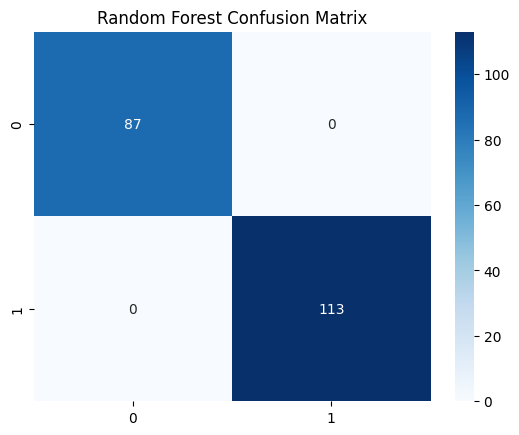

In [5]:
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_scaled, y_train)
y_pred_rf = rf.predict(X_test_scaled)
y_prob_rf = rf.predict_proba(X_test_scaled)[:, 1]

print("Random Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest Confusion Matrix")
plt.show()



**LSTM Model**

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.7152 - loss: 0.6627 - val_accuracy: 0.9937 - val_loss: 0.6166
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9471 - loss: 0.5981 - val_accuracy: 1.0000 - val_loss: 0.5615
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9908 - loss: 0.5428 - val_accuracy: 1.0000 - val_loss: 0.5041
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9986 - loss: 0.4755 - val_accuracy: 1.0000 - val_loss: 0.4431
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.4132 - val_accuracy: 1.0000 - val_loss: 0.3821
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 1.0000 - loss: 0.3464 - val_accuracy: 1.0000 - val_loss: 0.3227
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 1.0000 - loss: 0.2955 - val_accuracy: 1.0000 - val_loss: 0.2687
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 1.0000 - loss: 0.2364 - val_accuracy: 1.0000 - val_loss: 0.2215
E

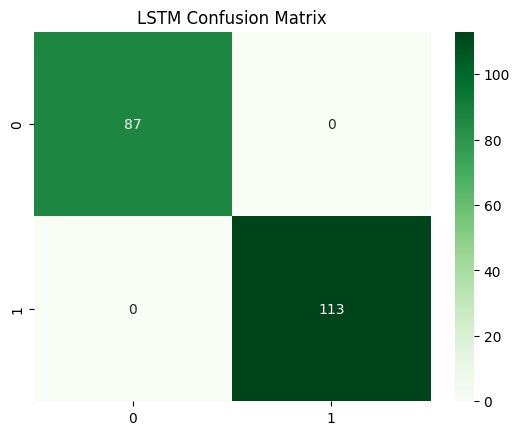

In [7]:
# Reshape input for LSTM: [samples, timesteps, features]
X_lstm_train = np.reshape(X_train_scaled, (X_train_scaled.shape[0], 1, X_train_scaled.shape[1]))
X_lstm_test = np.reshape(X_test_scaled, (X_test_scaled.shape[0], 1, X_test_scaled.shape[1]))

model = Sequential()
model.add(LSTM(64, input_shape=(1, X_train_scaled.shape[1]), return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X_lstm_train, y_train, epochs=20, batch_size=32, validation_split=0.2, verbose=1)

y_prob_lstm = model.predict(X_lstm_test).flatten()
y_pred_lstm = (y_prob_lstm > 0.5).astype(int)

print("LSTM Classification Report:\n", classification_report(y_test, y_pred_lstm))
sns.heatmap(confusion_matrix(y_test, y_pred_lstm), annot=True, fmt='d', cmap='Greens')
plt.title("LSTM Confusion Matrix")
plt.show()


**Autoencoder for Anomaly Detection**

Epoch 1/20


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 1.0586 - val_loss: 0.9895
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.9535 - val_loss: 0.9379
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.8887 - val_loss: 0.8800
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.8097 - val_loss: 0.8055
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.7440 - val_loss: 0.7276
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.6637 - val_loss: 0.6596
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.5970 - val_loss: 0.6039
Epoch 8/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.5509 - val_loss: 0.5496
Epoch 9/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.4983 - val_loss: 0.5054
Epoch 10/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.4508 - val_loss: 0.4647
Epoch 11/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4188 - val_loss: 0.4262
Epoch 12/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3763 - val_loss:

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
Autoencoder Classification Report:
               precision    recall  f1-score   support

           0       0.44      0.76      0.56        87
           1       0.58      0.26      0.36       113

    accuracy                           0.47       200
   macro avg       0.51      0.51      0.46       200
weighted avg       0.52      0.47      0.44       200



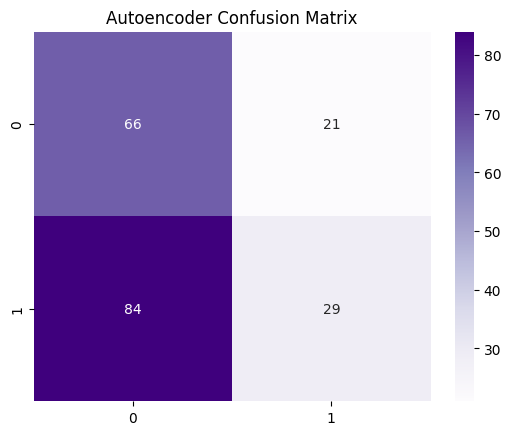

In [8]:
from sklearn.metrics import precision_recall_fscore_support

autoencoder = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(X_train_scaled.shape[1], activation='linear')
])

autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train_scaled, X_train_scaled, epochs=20, batch_size=32, validation_split=0.1, verbose=1)

reconstructions = autoencoder.predict(X_test_scaled)
mse = np.mean(np.power(X_test_scaled - reconstructions, 2), axis=1)
threshold = np.percentile(mse, 75)
y_pred_ae = (mse > threshold).astype(int)

print("Autoencoder Classification Report:\n", classification_report(y_test, y_pred_ae))
sns.heatmap(confusion_matrix(y_test, y_pred_ae), annot=True, fmt='d', cmap='Purples')
plt.title("Autoencoder Confusion Matrix")
plt.show()



<ipython-input-9-ec292aa1e2b9>:5: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



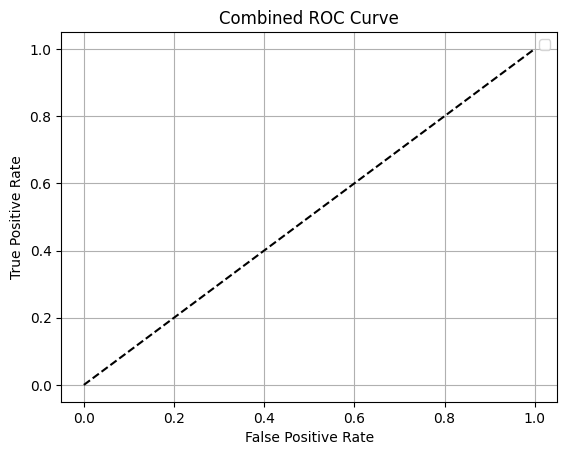

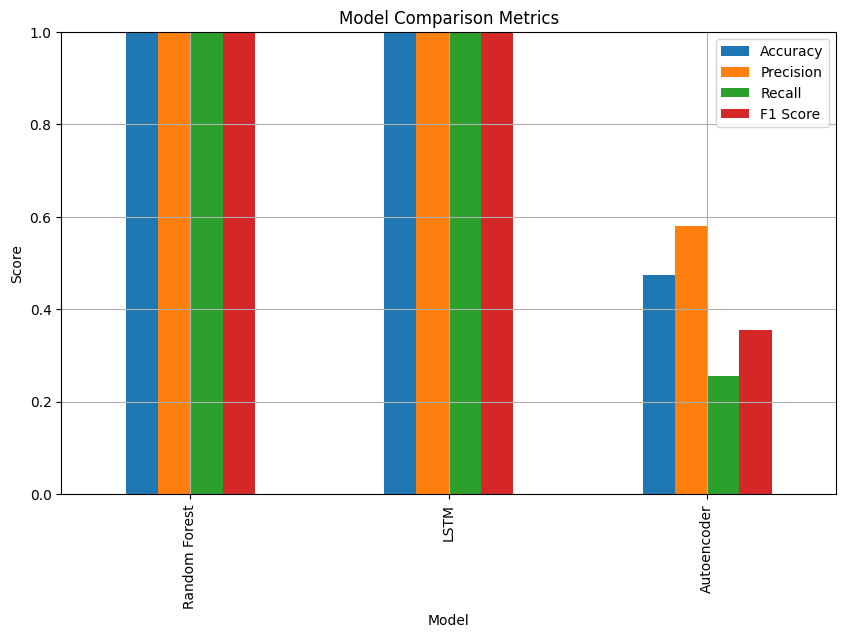

,Accuracy,Precision,Recall,F1 Score
Model,,,,
Random Forest,1.000,1.00,1.000000,1.000000
LSTM,1.000,1.00,1.000000,1.000000
Autoencoder,0.475,0.58,0.256637,0.355828


In [9]:
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Combined ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# Performance Summary Table
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

models = {
    'Random Forest': (y_test, y_pred_rf),
    'LSTM': (y_test, y_pred_lstm),
    'Autoencoder': (y_test, y_pred_ae),
}

summary = []

for name, (true, pred) in models.items():
    summary.append({
        'Model': name,
        'Accuracy': accuracy_score(true, pred),
        'Precision': precision_score(true, pred),
        'Recall': recall_score(true, pred),
        'F1 Score': f1_score(true, pred)
    })

performance_df = pd.DataFrame(summary)
performance_df.set_index('Model', inplace=True)
performance_df.plot(kind='bar', figsize=(10, 6), title="Model Comparison Metrics")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid()
plt.show()

performance_df


In [10]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(rf, X_train_scaled, y_train, cv=5, scoring='accuracy')
print("Random Forest CV Accuracy:", np.mean(cv_scores))


Random Forest CV Accuracy: 1.0


In [11]:
from scipy.stats import ttest_rel

# Compare RF and LSTM predictions
t_stat, p_val = ttest_rel(y_pred_rf, y_pred_lstm)
print(f"T-statistic: {t_stat}, P-value: {p_val}")


T-statistic: nan, P-value: nan


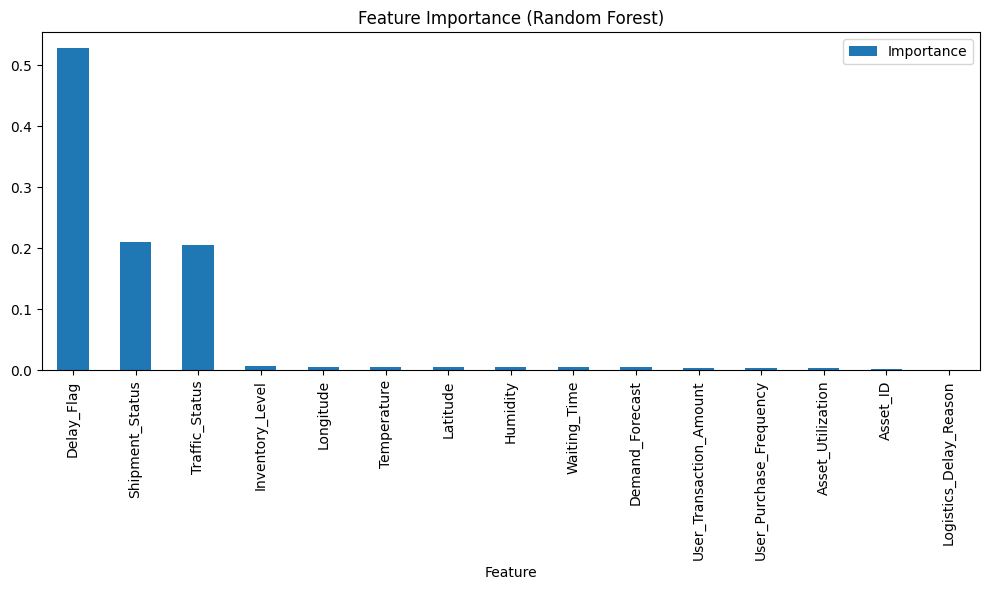

In [12]:
importances = rf.feature_importances_
feat_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feat_df.sort_values(by='Importance', ascending=False).plot.bar(x='Feature', figsize=(10, 6), title="Feature Importance (Random Forest)")
plt.tight_layout()
plt.show()
